# Classification

Guess what kind of wine is being reviewed

Ling 583  
April 5, 2018  
Sample solution

In [24]:
import pandas as pd
import spacy
from cytoolz import *

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.dummy import *
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.metrics import *

In [3]:
import spacy
nlp = spacy.load('en')

## 1. Prepare data

In [4]:
df = pd.read_msgpack('http://bulba.sdsu.edu/wine.dat')

In [7]:
def tokenize(text):
    return [tok.orth_ for tok in nlp.tokenizer(text)]
df['tokens'] = df['review_text'].apply(tokenize)

## 2. Baseline

In [8]:
folds = StratifiedKFold(shuffle=True, n_splits=10, random_state=10)

In [9]:
baseline = make_pipeline(CountVectorizer(analyzer=identity), 
                         DummyClassifier('most_frequent'))

In [10]:
base_score = cross_val_score(baseline, df['tokens'], df['wine_variant'], cv=folds)
base_score.mean(), base_score.std()

(0.25, 0.0)

## 3. Simple Logistic Regression

In [11]:
lr = make_pipeline(CountVectorizer(analyzer=identity), 
                   LogisticRegression())

In [12]:
lr_score = cross_val_score(lr, df['tokens'], df['wine_variant'], cv=folds)
lr_score.mean(), lr_score.std()

(0.77479999999999993, 0.0060702141642614213)

## 4. Best classifier pipeline

In [13]:
best = make_pipeline(CountVectorizer(analyzer=identity), 
                     TfidfTransformer(),
                     LogisticRegression())

In [15]:
params = {'logisticregression__C': [ 0.01, 0.1, 1.0 ],
          'tfidftransformer__norm': ['l2', None],
          'tfidftransformer__use_idf': [True, False],
          'tfidftransformer__sublinear_tf': [True, False],
          'countvectorizer__min_df': [2, 5],
          'countvectorizer__max_df': [0.25, 0.5]}
grid_search = GridSearchCV(best, params, n_jobs=-1, verbose=1, return_train_score=True)
grid_search.fit(df['tokens2'], df['wine_variant'])   

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x11832bd38>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1.0], 'tfidftransformer__norm': ['l2', None], 'tfidftransformer__use_idf': [True, False], 'tfidftransformer__sublinear_tf': [True, False], 'countvectorizer__min_df': [2, 5], 'countvectorizer__max_df': [0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [16]:
grid_search.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__min_df': 2,
 'logisticregression__C': 1.0,
 'tfidftransformer__norm': 'l2',
 'tfidftransformer__sublinear_tf': True,
 'tfidftransformer__use_idf': True}

In [17]:
best.set_params(**grid_search.best_params_)
best_score = cross_val_score(best, df['tokens'], df['wine_variant'], cv=folds)
best_score.mean(), best_score.std()

(0.78669999999999995, 0.0065352888229977977)

## 5. Error analysis and discussion

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df['tokens'], df['wine_variant'], 
                                                shuffle=True, test_size=0.2)

In [20]:
best.fit(Xtrain, ytrain)
ypred = best.predict(Xtest)

In [21]:
print(classification_report(ytest, ypred))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.71      0.75      0.73      2027
        Chardonnay       0.84      0.86      0.85      2008
            Merlot       0.71      0.69      0.70      1967
   Sauvignon Blanc       0.89      0.85      0.87      1998

       avg / total       0.79      0.79      0.79      8000



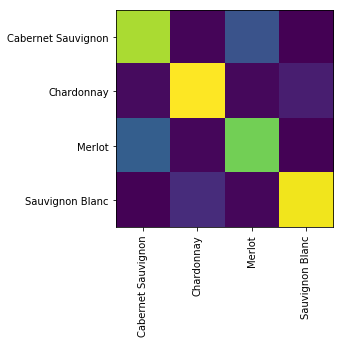

In [42]:
variants = pd.unique(df['wine_variant'])
cm = confusion_matrix(ytest, ypred, labels=variants)
plt.imshow(cm)
plt.xticks(range(len(variants)), variants, rotation=90)
plt.yticks(range(len(variants)), variants, rotation=0)
plt.show()

In [44]:
[' '.join(t) for t in Xtest[(ytest!=ypred)&(ypred=='Merlot')]]

['Very dark purple and a little vanilla on the noise . Needs time to open . i gave it an hour and it opened up . Good wine for the price .',
 "Red / purple in glass ; chocolate and cherries on the nose ; light mouthfeel with sweet berries predominant ; not much structure to speak of ; a bit hot and quick on the finish . Decent for an I - don't - want - to - think - about - my - wine glass .",
 'Blackberry and oak on the nose , flavors of tart cherry , forrest floor and spice . I agree with others that this will out last the 2013 window .',
 "Nothing really wrong with the wine , the 98 vintage was weak anyway . The wine is very soft , hints of fruit remain , even the finish is OK , there just is n't a lot here .",
 'Full bodied , but luscious - a Merlot drinkers Cabernet - with a soft - texture and gobs of fruit , this offers generous aromas of black cherry , plum , bell pepper and a big dollop of vanilla . Well integrated with velvety tannins and very persistent - though very oaky - bl